# TP cinématique et dynamique en analyse du mouvement 3
**Charles Pontonnier - Franck Multon**

## Post processing des données cinématiques et dynamiques



## Setup du Notebook

In [56]:
#Import des librairies de calcul et de visu
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal

d=np.zeros(200) #pour les bugs
d2=np.zeros(200)

## Récupération des angles articulaires

In [57]:
# Fonction de récupération des données d'OpenSim
def readMotionFile(filename):
    """ Reads OpenSim .sto files.
    Parameters
    ----------
    filename: absolute path to the .sto file
    Returns
    -------
    header: the header of the .sto
    labels: the labels of the columns
    data: an array of the data
    """

    if not os.path.exists(filename):
        print('file do not exists')

    file_id = open(filename, 'r')

    # read header
    next_line = file_id.readline()
    header = [next_line]
    nc = 0
    nr = 0
    while not 'endheader' in next_line:
        if 'datacolumns' in next_line:
            nc = int(next_line[next_line.index(' ') + 1:len(next_line)])
        elif 'datarows' in next_line:
            nr = int(next_line[next_line.index(' ') + 1:len(next_line)])
    
        elif 'nColumns' in next_line:
            nc = int(next_line[next_line.index('=') + 1:len(next_line)])
        elif 'nRows' in next_line:
            nr = int(next_line[next_line.index('=') + 1:len(next_line)])

        next_line = file_id.readline()
        header.append(next_line)

    # process column labels
    next_line = file_id.readline()
    if next_line.isspace() == True:
        next_line = file_id.readline()

    labels = next_line.split()

    # get data
    data = []
    for i in range(1, nr + 1):
        d = [float(x) for x in file_id.readline().split()]
        data.append(d)

    file_id.close()

    return header, labels, data

## Analyse cinématique
Dans cette partie nous analysons les angles de flexion de l'épaule et du coude armés lors de la fente


<font color='green'>**Question 6: A partir de la fonction ci-dessus, récupérer les données de cinématique. Imprimer les labels associés et récupérer les colonnes correspondant aux angles de flexion et adduction de l'épaule, et de flexion du coude.**</font>

In [58]:
#récupération des données de cinématique
# faire appel à la fonction ci-dessus
# [h,l,d]=readMotionFile('../MyPath/MyFile.mot')

In [59]:
#impression des labels


In [66]:
# Récupération des angles du coude et de l'épaule
flex_shoulder_l=np.zeros(len(d))
add_shoulder_l=np.zeros(len(d))
flex_elbow_l=np.zeros(len(d))

time=np.zeros(len(d))

#syntaxe pour récupérer la 33ème colonne de d :
# d[i][33]

#for i in range(len(d)):
#    time[i]=d[i][0]



<font color='green'>**Question 7: Tracer les angles de l'épaule et du coude. Quelles stratégies d'adaptation décelez vous dans ces données ?**</font>

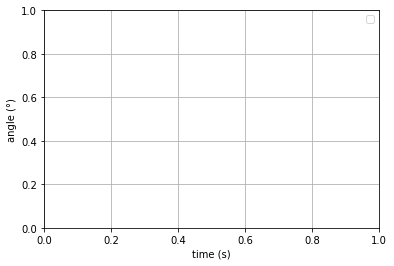

In [67]:
#tracé des données épaule et coude

plt.grid()
plt.legend(['Shoulder flexion','Shoulder adduction','Elbow flexion'])
plt.xlabel('time (s)')
plt.ylabel('angle (°)')
plt.show()



## Analyse Dynamique
Dans cette partie on analyse le couple au niveau du genou d'appui lors de la fente.

<font color='green'>**Question 8: ouvrir le fichier de résultats de dynamique inverse. Imprimer les labels et identifier la colonne correspondant au moment au niveau du genou droit.**</font>

In [68]:
#Récupération des données dynamiques (couples articulaires)
#[h2,l2,d2]=readMotionFile('../Mypath/MyFile.sto')

In [69]:
#impression des labels


On va à présent normaliser le couple au genou à partir de données issues du papier suivant (relation couple-angle-vitesse obtenue expérimentalement sur un ergomètre isocinétique):

Anderson, D. E., Madigan, M. L., & Nussbaum, M. A. (2007). Maximum voluntary joint torque as a function of joint angle and angular velocity: model development and application to the lower limb. Journal of biomechanics, 40(14), 3105-3113.

![alt text](anderson2007.png "Title")

In [72]:
#Fonction donnant le couple maximal d'extension du genou en fonction de l'angle et de la vitesse angulaire
def anderson_kneef_1825(q,dq,bm,h):
    #Anderson, D. E., Madigan, M. L., & Nussbaum, M. A. (2007). 
    #Maximum voluntary joint torque as a function of joint angle and angular velocity: model development and application to the lower limb. 
    #Journal of biomechanics, 40(14), 3105-3113.
    #q joint angle in rad
    #dq joint velocity in rad/s
    #bw body weight in kg
    #h height in m    
    
    C1=0.163*h*bm*9.81;
    C2=1.258;
    C3=1.133;
    C4=1.517;
    C5=3.952;
    C6=0.095;
    B1=0;
    k1=0;
    B2=-6.25;
    k2=-4.521;

    Cmax=C1*np.cos(C2*(q-C3))*((2*C4*C5+dq*(C5-3*C4))/(2*C4*C5+dq*(2*C5-4*C4)));

    if dq<0:
        Cmax=Cmax*(1-C6*dq);
    
    return Cmax


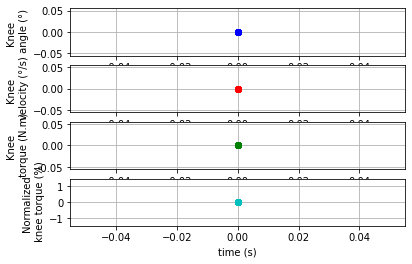

In [73]:
# Récupérer l'angle de flexion du genou dans les données de cinématique, et le couple de flexion dans les données de dynamique

flex_knee_angle_r=np.zeros(len(d2))
flex_knee_torque_r=np.zeros(len(d2))
flex_knee_torque_max_r=np.zeros(len(d2))

#récupération de l'angle et du couple de flexion/extension du genou
#for i in range(len(d)):


# filtre passe-bas, 6Hz, no phase shift
b, a = signal.butter(4, 6, btype='low', analog=False, output='ba', fs=250)
flex_knee_angle_r = signal.filtfilt(b, a, flex_knee_angle_r, padlen=150)
#obtention de la vitesse angulaire du genou
flex_knee_velocity_r =np.diff(flex_knee_angle_r)*250
#obtention du couple normalisé
for i in range(len(d)-1):
    flex_knee_torque_max_r[i]=flex_knee_torque_r[i]/anderson_kneef_1825(flex_knee_angle_r[i]*np.pi/180,flex_knee_velocity_r[i]*np.pi/180,85.5,1.77)


plt.subplot(4,1,1)
plt.plot(time,flex_knee_angle_r,'ob') #arm flexion l 33, elbow 36
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Knee \n angle (°)')
plt.subplot(4,1,2)
plt.plot(time[:-1],flex_knee_velocity_r,'or') #arm flexion l 33, elbow 36
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Knee \n velocity (°/s)')
plt.subplot(4,1,3)
plt.plot(time,flex_knee_torque_r,'og') #arm flexion l 33, elbow 36
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Knee \n torque (N.m)')
plt.subplot(4,1,4)
plt.plot(time,flex_knee_torque_max_r,'oc') #arm flexion l 33, elbow 36
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Normalized \n knee torque (%)')
plt.ylim(-1.5, 1.5)
plt.show()